In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

pd.set_option("mode.copy_on_write", True)

# Load merged dataset
url= "https://raw.githubusercontent.com/MIDS-at-Duke/pds-2025-opioids-study_on_opioids/refs/heads/merging/final_merged.csv?token=GHSAT0AAAAAADQIFFGRHA6LKTZ6SZK4YG7E2JLS2DQ"
data = pd.read_csv(url)


In [2]:
# View merged data
data.head()

,State,County,Total_MME,County.1,County Code,Drug/Alcohol Induced Cause,Drug/Alcohol Induced Cause Code,Deaths,year,Population
0,GA,APPLING,5201.267675,"Appling County, GA",13001,All other non-drug and non-alcohol causes,O9,215,2015,18423
1,GA,ATKINSON,1023.390277,"Atkinson County, GA",13003,All other non-drug and non-alcohol causes,O9,81,2015,8340
2,GA,BACON,3824.818008,"Bacon County, GA",13005,All other non-drug and non-alcohol causes,O9,133,2015,11231
3,GA,BALDWIN,7352.035690,"Baldwin County, GA",13009,All other non-drug and non-alcohol causes,O9,424,2015,45549
4,GA,BANKS,2115.657581,"Banks County, GA",13011,All other non-drug and non-alcohol causes,O9,183,2015,18381


In [3]:
# List of target state codes for Washington's control group
wash_controls = ["WA", "OR", "ID", "MT"]

# Make sure the State column exists before checking values
if "State" in data.columns:
    # Identify which of the desired codes are present in the dataset
    states_found = [code for code in wash_controls if code in data["State"].unique()]
    states_missing = [code for code in wash_controls if code not in data["State"].unique()]

    print("States found in dataset:", states_found)
    print("States NOT found in dataset:", states_missing)
else:
    print("Column 'State' does not exist in final_merged.")


States found in dataset: ['WA', 'OR', 'ID', 'MT']
States NOT found in dataset: []


In [4]:
# Parallel trend check for selected states

states_to_check = ["WA", "OR", "ID", "MT"]
panel = data[
    (data["State"].isin(states_to_check)) &
    (data["year"] >= 2006) &
    (data["year"] <= 2009)
][["County Code", "State", "County", "year", "Population", "Deaths"]].copy()
panel.head()


,County Code,State,County,year,Population,Deaths
5382,30001,MT,BEAVERHEAD,2006,9012,81
5383,30001,MT,BEAVERHEAD,2007,9028,76
5384,30001,MT,BEAVERHEAD,2008,9166,70
5385,30001,MT,BEAVERHEAD,2009,9200,81
5392,30003,MT,BIG HORN,2006,12540,118


In [5]:
# Compute overdose death rate per 100,000
panel["death_rate_per_100k"] = panel["Deaths"] / panel["Population"] * 100000

In [6]:
# Create "treated" indicator (e.g. treated = 1 for Washington, 0 otherwise)
panel["treated_state"] = (panel["State"] == "WA").astype(int)

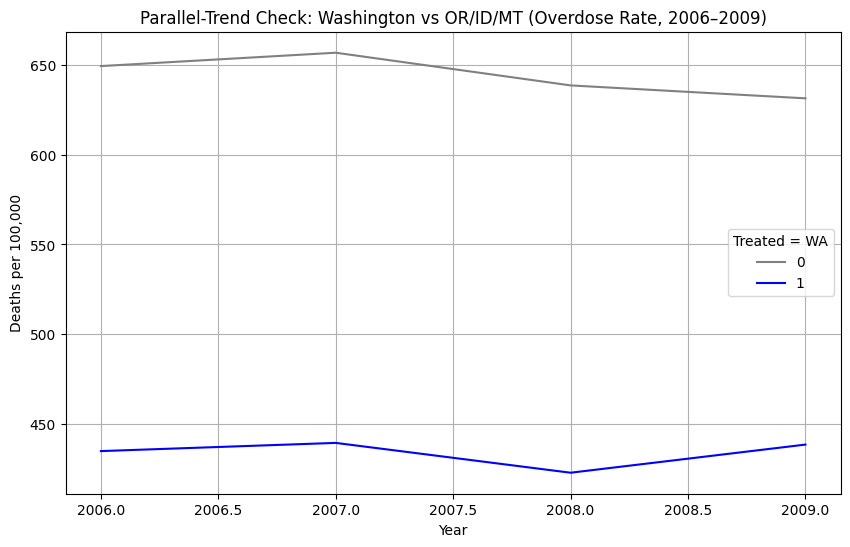

In [7]:
# Plot pre-treatment trends: all control states vs WA

plt.figure(figsize=(10,6))
sns.lineplot(
    data=panel,
    x="year",
    y="death_rate_per_100k",
    hue="treated_state",
    palette={1: "blue", 0: "gray"},
    estimator="mean",
    errorbar=None
)
plt.title("Parallel‐Trend Check: Washington vs OR/ID/MT (Overdose Rate, 2006–2009)")
plt.xlabel("Year")
plt.ylabel("Deaths per 100,000")
plt.legend(title="Treated = WA")
plt.grid(True)
plt.show()

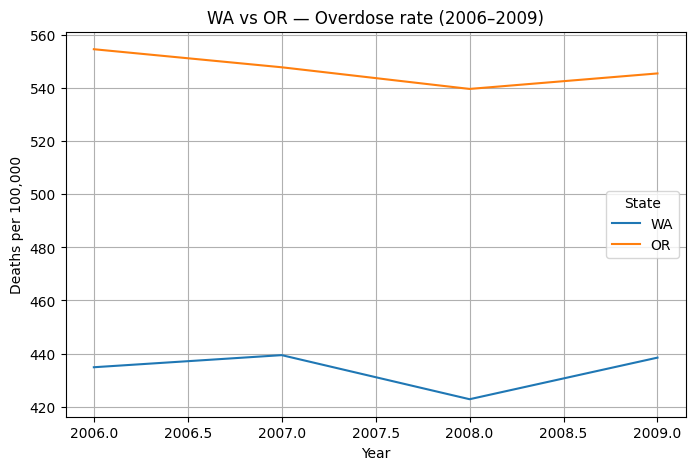

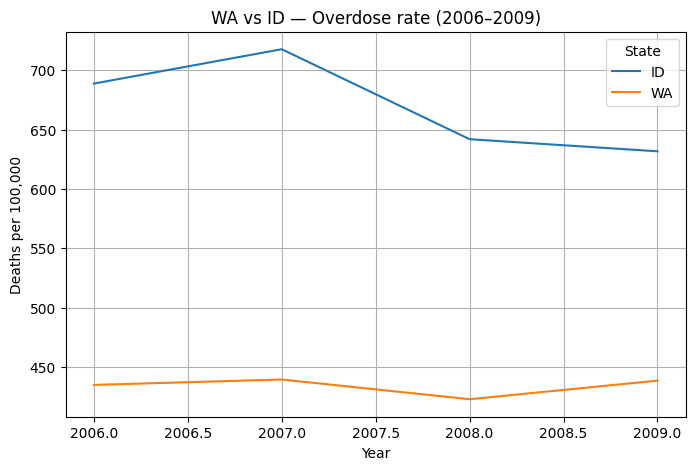

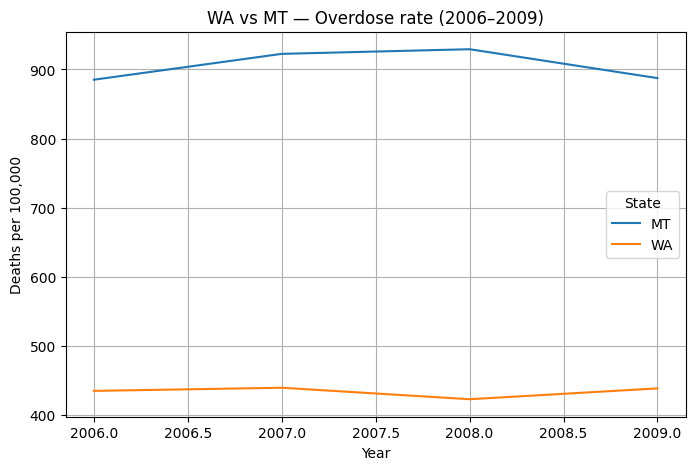

In [8]:
# Plot WA vs each control state individually
for ctrl in ["OR","ID","MT"]:
    df_ctrl = panel[panel["State"].isin(["WA", ctrl])]
    plt.figure(figsize=(8,5))
    sns.lineplot(
        data=df_ctrl,
        x="year",
        y="death_rate_per_100k",
        hue="State",
        estimator="mean",
        errorbar=None
    )
    plt.title(f"WA vs {ctrl} — Overdose rate (2006–2009)")
    plt.xlabel("Year")
    plt.ylabel("Deaths per 100,000")
    plt.grid(True)
    plt.show()

In [9]:
# Statistical test: does WA have a different pre-trend (death rate) vs controls?
model = smf.ols(formula="death_rate_per_100k ~ treated_state * year", data=panel).fit()
print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     death_rate_per_100k   R-squared:                       0.048
Model:                             OLS   Adj. R-squared:                  0.047
Method:                  Least Squares   F-statistic:                     220.7
Date:                 Sat, 29 Nov 2025   Prob (F-statistic):          9.72e-140
Time:                         19:45:03   Log-Likelihood:            -1.0022e+05
No. Observations:                13271   AIC:                         2.005e+05
Df Residuals:                    13267   BIC:                         2.005e+05
Df Model:                            3                                         
Covariance Type:             nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           1.516e

The pre-treatment OLS regression shows that the interaction term between Washington and year is statistically insignificant (p = 0.369). This indicates no evidence that Washington’s mortality trend from 2006–2009 differs from the comparison states (Oregon, Idaho, Montana). Therefore, the parallel-trends assumption is reasonably satisfied for overdose mortality, and these states can be used as valid controls for Washington in a difference-in-differences design.

### Parallel Trends Check for Opioid Deaths Per Capita

In [10]:
data

,State,County,Total_MME,County.1,County Code,Drug/Alcohol Induced Cause,Drug/Alcohol Induced Cause Code,Deaths,year,Population
0,GA,APPLING,5201.267675,"Appling County, GA",13001,All other non-drug and non-alcohol causes,O9,215,2015,18423
1,GA,ATKINSON,1023.390277,"Atkinson County, GA",13003,All other non-drug and non-alcohol causes,O9,81,2015,8340
2,GA,BACON,3824.818008,"Bacon County, GA",13005,All other non-drug and non-alcohol causes,O9,133,2015,11231
3,GA,BALDWIN,7352.035690,"Baldwin County, GA",13009,All other non-drug and non-alcohol causes,O9,424,2015,45549
4,GA,BANKS,2115.657581,"Banks County, GA",13011,All other non-drug and non-alcohol causes,O9,183,2015,18381
...,...,...,...,...,...,...,...,...,...,...
271962,ID,WASHINGTON,1715.557262,"Washington County, ID",16087,All other non-drug and non-alcohol causes,O9,117,2010,10177
271963,ID,WASHINGTON,2096.665016,"Washington County, ID",16087,All other non-drug and non-alcohol causes,O9,118,2011,10136
271964,ID,WASHINGTON,2119.290127,"Washington County, ID",16087,All other non-drug and non-alcohol causes,O9,110,2012,10030
271965,ID,WASHINGTON,2264.381253,"Washington County, ID",16087,All other non-drug and non-alcohol causes,O9,137,2013,9916


In [11]:

panel["opioid_per_100k"] = (panel["Deaths"] / panel["Population"]) * 100000


In [12]:
df_opioid = data[
    (data["State"].isin(wash_controls))   # your selected WA + controls
    & (data["year"] >= 2006)
    & (data["year"] <= 2009)
][["County Code", "State", "County", "year", "Population", "Total_MME"]].copy()

df_opioid["opioid_per_capita"] = df_opioid["Total_MME"] / df_opioid["Population"]


In [13]:
df_opioid["treated"] = (df_opioid["State"] == "WA").astype(int)

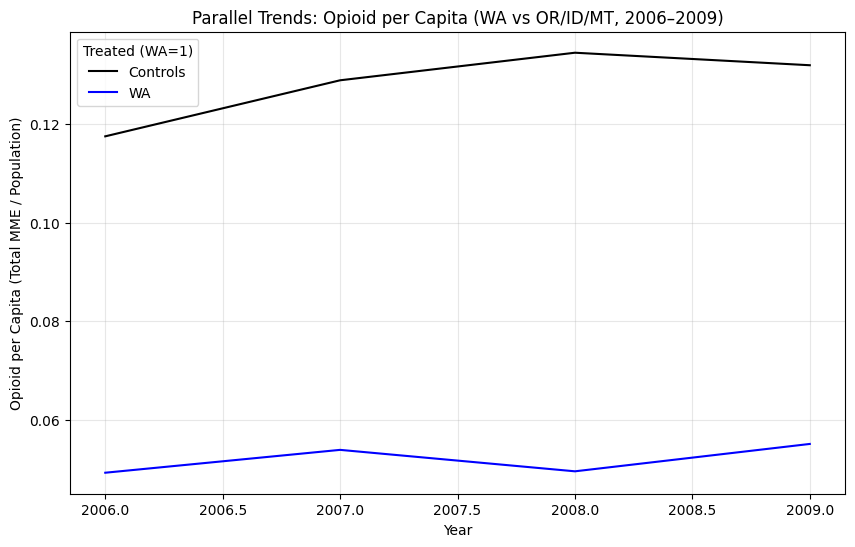

In [14]:
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=df_opioid,
    x="year",
    y="opioid_per_capita",
    hue="treated",
    estimator="mean",
    errorbar=None,
    palette={1: "blue", 0: "black"},
)

plt.title("Parallel Trends: Opioid per Capita (WA vs OR/ID/MT, 2006–2009)")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita (Total MME / Population)")
plt.grid(True, alpha=0.3)
plt.legend(title="Treated (WA=1)", labels=["Controls", "WA"])
plt.show()


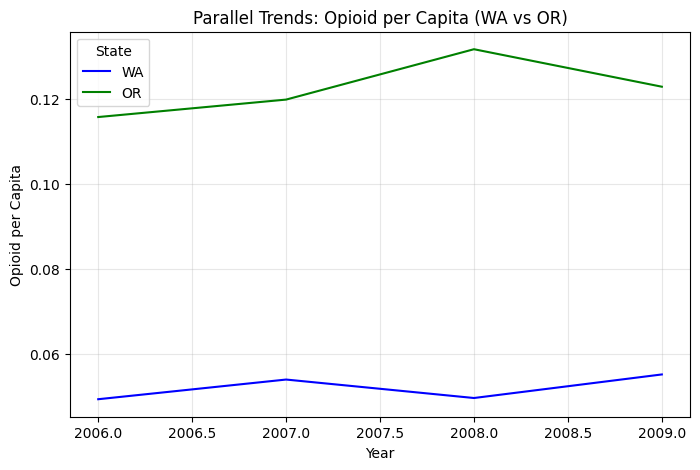

In [15]:
# WA vs Oregon

states_or = ["WA", "OR"]
df_or = df_opioid[df_opioid["State"].isin(states_or)].copy()

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=df_or,
    x="year",
    y="opioid_per_capita",
    hue="State",
    estimator="mean",
    errorbar=None,
    palette={"WA": "blue", "OR": "green"},
)

plt.title("Parallel Trends: Opioid per Capita (WA vs OR)")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita")
plt.grid(True, alpha=0.3)
plt.legend(title="State")
plt.show()


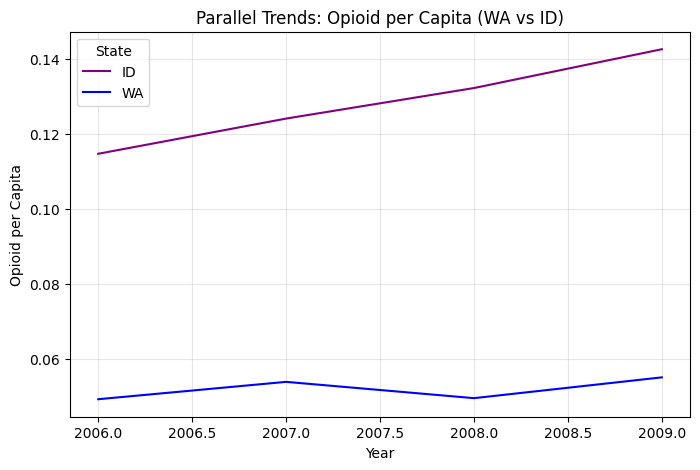

In [16]:
states_id = ["WA", "ID"]
df_id = df_opioid[df_opioid["State"].isin(states_id)].copy()

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=df_id,
    x="year",
    y="opioid_per_capita",
    hue="State",
    estimator="mean",
    errorbar=None,
    palette={"WA": "blue", "ID": "purple"},
)

plt.title("Parallel Trends: Opioid per Capita (WA vs ID)")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita")
plt.grid(True, alpha=0.3)
plt.legend(title="State")
plt.show()


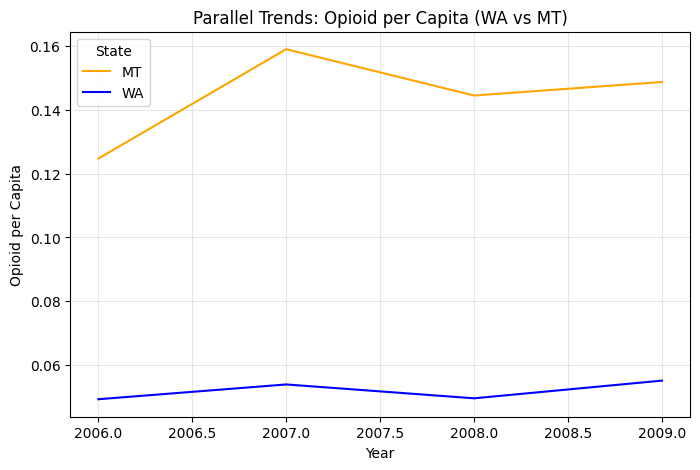

In [17]:
states_mt = ["WA", "MT"]
df_mt = df_opioid[df_opioid["State"].isin(states_mt)].copy()

plt.figure(figsize=(8, 5))
sns.lineplot(
    data=df_mt,
    x="year",
    y="opioid_per_capita",
    hue="State",
    estimator="mean",
    errorbar=None,
    palette={"WA": "blue", "MT": "orange"},
)

plt.title("Parallel Trends: Opioid per Capita (WA vs MT)")
plt.xlabel("Year")
plt.ylabel("Opioid per Capita")
plt.grid(True, alpha=0.3)
plt.legend(title="State")
plt.show()


In [18]:
model_opioid = smf.ols(
    formula="opioid_per_capita ~ treated * year",
    data=df_opioid
).fit()

print(model_opioid.summary())


                            OLS Regression Results                            
Dep. Variable:      opioid_per_capita   R-squared:                       0.108
Model:                            OLS   Adj. R-squared:                  0.108
Method:                 Least Squares   F-statistic:                     535.9
Date:                Sat, 29 Nov 2025   Prob (F-statistic):               0.00
Time:                        19:45:30   Log-Likelihood:                 10763.
No. Observations:               13271   AIC:                        -2.152e+04
Df Residuals:                   13267   BIC:                        -2.149e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -9.5955      2.654     -3.615   